<h1>Mnist 多层感知器<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#导入工具包" data-toc-modified-id="导入工具包-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>导入工具包</a></span></li><li><span><a href="#导入数据" data-toc-modified-id="导入数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>导入数据</a></span></li><li><span><a href="#构建多层感知器" data-toc-modified-id="构建多层感知器-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>构建多层感知器</a></span></li><li><span><a href="#结论" data-toc-modified-id="结论-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>结论</a></span></li></ul></div>

## 导入工具包

In [48]:
"""A very simple MNIST classifier.
See extensive documentation at
https://www.tensorflow.org/get_started/mnist/beginners
"""
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

FLAGS = None
%matplotlib inline

## 导入数据

In [32]:
# Import data
data_dir = 'E:/AI/00/data/Mnist/input_data'
mnist = input_data.read_data_sets(data_dir, one_hot=True)

Extracting E:/AI/00/data/Mnist/input_data\train-images-idx3-ubyte.gz
Extracting E:/AI/00/data/Mnist/input_data\train-labels-idx1-ubyte.gz
Extracting E:/AI/00/data/Mnist/input_data\t10k-images-idx3-ubyte.gz
Extracting E:/AI/00/data/Mnist/input_data\t10k-labels-idx1-ubyte.gz


## 构建多层感知器

In [33]:
class mnist_go(object):
    '''
    默认三层隐层,每层神经元数量分别为n1=200,n2=200,n3=200,
    激活函数逐层为relu6,tanh,relu
    交叉熵计算时自带softmax激活
    next_batch为100,循环20000次
    每循环300次将计算结果添加进a_ce
    self.a_ce={'train':[正确率],'test':[正确率],'c_e':[交叉熵]}
    默认参数test中正确率为98.3%左右
    '''

    def __init__(self,n1=200,n2=200,n3=200,stddev=0.1,learning_rate=0.5,for_=10000,batch=100,mnist=mnist):
        self.for_=for_
        # 初始化模型参数
        x  = tf.placeholder(tf.float32, [None, 784])
        # 初始化各层权重
        W1 = tf.Variable(tf.random_normal([784,n1],mean=0,stddev=stddev,seed=66))
        b1 = tf.Variable(tf.zeros([n1]))
        W2 = tf.Variable(tf.truncated_normal([n1,n2],mean=0,stddev=stddev,seed=66))
        b2 = tf.Variable(tf.zeros([n2]))
        W3 = tf.Variable(tf.truncated_normal([n2,n3],mean=0,stddev=stddev,seed=66))
        b3 = tf.Variable(tf.zeros([n3]))
        W4 = tf.Variable(tf.zeros([n3,10]))
        b4 = tf.Variable(tf.zeros([10]))
        # 添加隐层
        hidden1 = tf.nn.relu6(tf.matmul(x,W1)+b1)
        hidden2 = tf.nn.tanh(tf.matmul(hidden1,W2)+b2)
        hidden3 = tf.nn.relu(tf.matmul(hidden2,W3)+b3)
        # 设置logit
        y = tf.matmul(hidden3, W4) + b4
        # 初始化y_truth
        y_ = tf.placeholder(tf.float32, [None, 10])
        # 设置交叉熵(不加正则)
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
        # 设置随机梯度下降
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        # 设置Session
        sess = tf.Session()
        init_op = tf.global_variables_initializer()#初始化可变变量
        sess.run(init_op)
        # 开始训练,Train
        # 设置正确率计算公式
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        a_ce={'train':[],'test':[],'c_e':[]}#用于存放正确率和交叉熵
        #{'acc': accuracy, 'c_e': cross_entropy}
        for _ in range(for_):
            # 每次获取小批量的数据
            batch_xs, batch_ys = mnist.train.next_batch(batch)
            # 执行train_step
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
            if _ %200==0:
                #将正确率和交叉熵分别添加进各自的list
                a_ce['test'].append(sess.run(accuracy, feed_dict={x: mnist.test.images,y_: mnist.test.labels}))
                a_ce['c_e'].append(sess.run(cross_entropy, feed_dict={x: mnist.test.images,y_: mnist.test.labels}))
                a_ce['train'].append(sess.run(accuracy, feed_dict={x: mnist.train.images,y_: mnist.train.labels}))
            if _ %1000==0:
                print('the accuracy of test is %f in %d step'%(a_ce['test'][int(_/200)], _))
        self.a_ce = a_ce

    def plot(self):
        '''
        删除a_ce的[0,300,600,900]点
        并将正确率和交叉熵曲线画出来
        '''
        # 将得到的正确率和交叉熵转换成DataFrame
        df=pd.DataFrame(data=self.a_ce
                        ,index=[x for x in range(self.for_) if x%200==0])
        # 删除前几行的异常样本
        df.drop([0,200,400,600,800],inplace=True)

        # 绘图
        # 子图一: 正确率
        ax1 = plt.figure(figsize=(8,6)).add_subplot(111)
        ax1.plot(df['train'], label='train', color='b')
        ax1.plot(df['test'], label='test', color='g')
        ax1.plot([1000,self.for_], [0.98,0.98], label='0.98', color='y')
        #ax1.set_ylim([0.970, 0.984])
        ax1.set_ylabel('accuracy')
        ax1.legend(loc=3)

        # 子图二: 交叉熵
        ax2 = ax1.twinx()  
        ax2.plot(df['c_e'],label='cross_entropy', color='r')
        #ax2.set_ylim([0.072, 0.100])
        ax2.set_ylabel('cross_entropy')
        ax2.legend(loc=4)

        plt.grid(True, linestyle = "-")
        plt.show()

In [34]:
n_100=mnist_go(n1=100)

the accuracy of test is 0.098000 in 0 step
the accuracy of test is 0.969900 in 1000 step
the accuracy of test is 0.971100 in 2000 step
the accuracy of test is 0.977300 in 3000 step
the accuracy of test is 0.977800 in 4000 step
the accuracy of test is 0.978300 in 5000 step
the accuracy of test is 0.979300 in 6000 step
the accuracy of test is 0.980000 in 7000 step
the accuracy of test is 0.979100 in 8000 step
the accuracy of test is 0.980200 in 9000 step


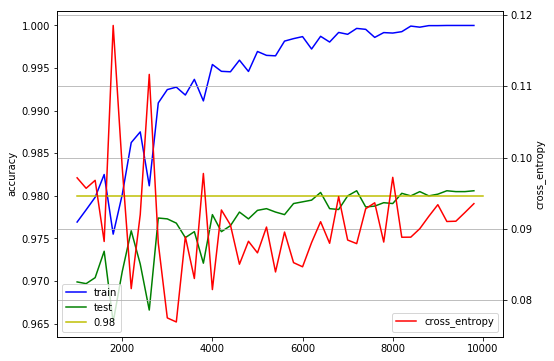

In [35]:
n_100.plot()

In [36]:
n_200=mnist_go()

the accuracy of test is 0.099800 in 0 step
the accuracy of test is 0.959200 in 1000 step
the accuracy of test is 0.976100 in 2000 step
the accuracy of test is 0.973000 in 3000 step
the accuracy of test is 0.976500 in 4000 step
the accuracy of test is 0.978500 in 5000 step
the accuracy of test is 0.978400 in 6000 step
the accuracy of test is 0.979800 in 7000 step
the accuracy of test is 0.980900 in 8000 step
the accuracy of test is 0.981300 in 9000 step


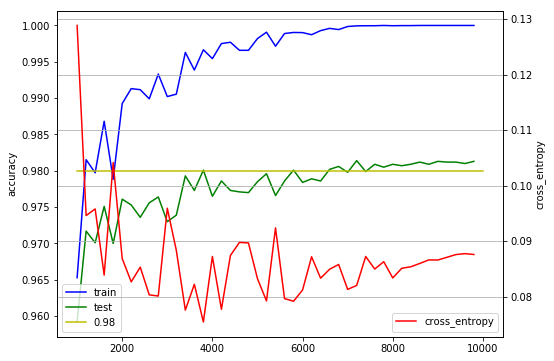

In [39]:
n_200.plot()

In [40]:
n_300=mnist_go(n1=300,)

the accuracy of test is 0.100300 in 0 step
the accuracy of test is 0.968900 in 1000 step
the accuracy of test is 0.976000 in 2000 step
the accuracy of test is 0.977200 in 3000 step
the accuracy of test is 0.978600 in 4000 step
the accuracy of test is 0.978900 in 5000 step
the accuracy of test is 0.980500 in 6000 step
the accuracy of test is 0.980800 in 7000 step
the accuracy of test is 0.981100 in 8000 step
the accuracy of test is 0.981100 in 9000 step


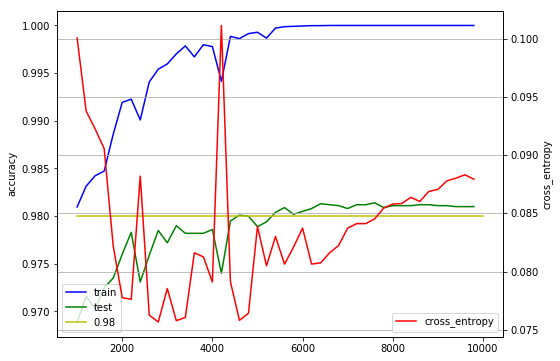

In [41]:
n_300.plot()

In [42]:
n_400=mnist_go(n1=400)

the accuracy of test is 0.097400 in 0 step
the accuracy of test is 0.971900 in 1000 step
the accuracy of test is 0.977400 in 2000 step
the accuracy of test is 0.979800 in 3000 step
the accuracy of test is 0.975600 in 4000 step
the accuracy of test is 0.981300 in 5000 step
the accuracy of test is 0.982200 in 6000 step
the accuracy of test is 0.982800 in 7000 step
the accuracy of test is 0.983000 in 8000 step
the accuracy of test is 0.983000 in 9000 step


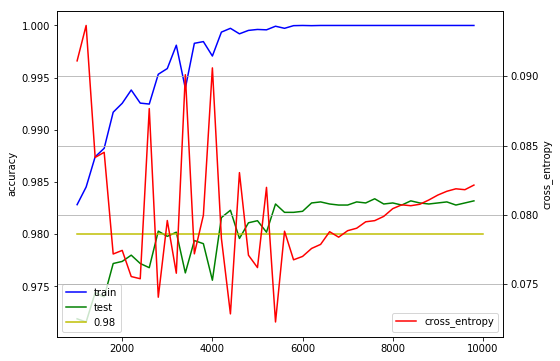

In [43]:
n_400.plot()

In [44]:
n_400_100=mnist_go(n1=400,n2=100)

the accuracy of test is 0.101000 in 0 step
the accuracy of test is 0.969300 in 1000 step
the accuracy of test is 0.972600 in 2000 step
the accuracy of test is 0.977500 in 3000 step
the accuracy of test is 0.977200 in 4000 step
the accuracy of test is 0.980700 in 5000 step
the accuracy of test is 0.982300 in 6000 step
the accuracy of test is 0.983100 in 7000 step
the accuracy of test is 0.983000 in 8000 step
the accuracy of test is 0.983400 in 9000 step


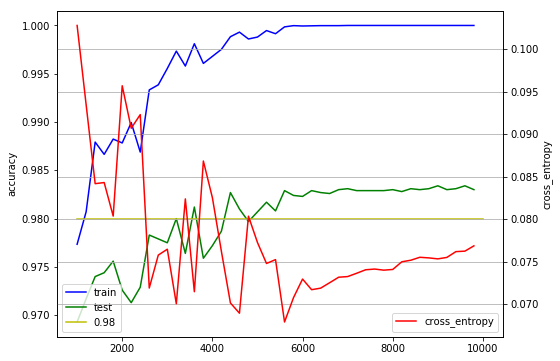

In [45]:
n_400_100.plot()

In [46]:
n_400_100_100=mnist_go(n1=400,n2=100,n3=100)

the accuracy of test is 0.159800 in 0 step
the accuracy of test is 0.969200 in 1000 step
the accuracy of test is 0.976600 in 2000 step
the accuracy of test is 0.979600 in 3000 step
the accuracy of test is 0.968200 in 4000 step
the accuracy of test is 0.975000 in 5000 step
the accuracy of test is 0.978500 in 6000 step
the accuracy of test is 0.979400 in 7000 step
the accuracy of test is 0.982500 in 8000 step
the accuracy of test is 0.981200 in 9000 step


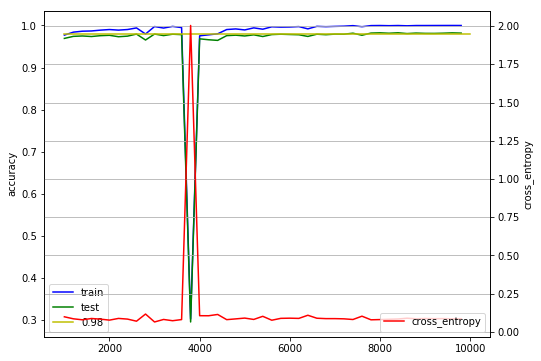

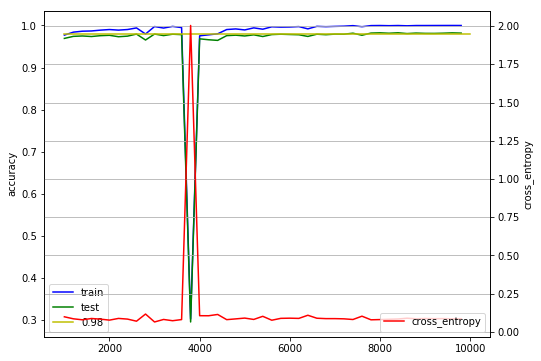

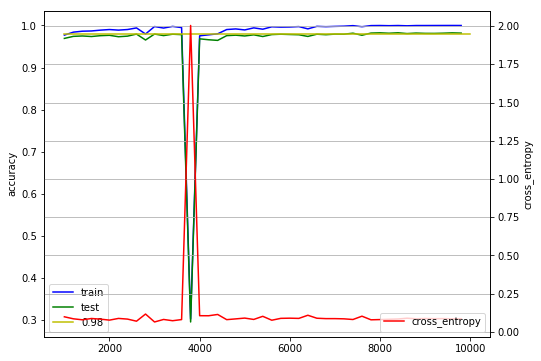

In [52]:
n_400_100_100.plot()

n_400_100_100.plot()
n_400_100_100.plot()

In [49]:
n_400_100_100.a_ce

{'c_e': [2.272985,
  0.19066648,
  0.17308359,
  0.12063901,
  0.1008917,
  0.099124275,
  0.08592327,
  0.079371594,
  0.08791687,
  0.083850145,
  0.07733359,
  0.08846136,
  0.084052905,
  0.07033734,
  0.11703877,
  0.0652234,
  0.08172046,
  0.07341196,
  0.08093323,
  2.004079,
  0.106236875,
  0.10593556,
  0.11433369,
  0.08043652,
  0.08541188,
  0.09062035,
  0.081784934,
  0.10226709,
  0.0766996,
  0.08893677,
  0.090007484,
  0.08861722,
  0.1091974,
  0.089694686,
  0.08713518,
  0.08713717,
  0.085786864,
  0.08136814,
  0.103077084,
  0.079404674,
  0.08091509,
  0.08287255,
  0.08469404,
  0.08989076,
  0.08609131,
  0.08779036,
  0.08686543,
  0.087137856,
  0.08559343,
  0.086632974],
 'test': [0.1598,
  0.9393,
  0.9445,
  0.9608,
  0.9674,
  0.9692,
  0.9741,
  0.975,
  0.9737,
  0.9757,
  0.9766,
  0.9732,
  0.9746,
  0.9795,
  0.9654,
  0.9796,
  0.9759,
  0.9792,
  0.9782,
  0.2949,
  0.9682,
  0.966,
  0.9645,
  0.9758,
  0.9769,
  0.975,
  0.9777,
  0.9737,
  

In [50]:
d=dict()
key='99'
d[key]=n_400_100_100.a_ce
d

{'99': {'c_e': [2.272985,
   0.19066648,
   0.17308359,
   0.12063901,
   0.1008917,
   0.099124275,
   0.08592327,
   0.079371594,
   0.08791687,
   0.083850145,
   0.07733359,
   0.08846136,
   0.084052905,
   0.07033734,
   0.11703877,
   0.0652234,
   0.08172046,
   0.07341196,
   0.08093323,
   2.004079,
   0.106236875,
   0.10593556,
   0.11433369,
   0.08043652,
   0.08541188,
   0.09062035,
   0.081784934,
   0.10226709,
   0.0766996,
   0.08893677,
   0.090007484,
   0.08861722,
   0.1091974,
   0.089694686,
   0.08713518,
   0.08713717,
   0.085786864,
   0.08136814,
   0.103077084,
   0.079404674,
   0.08091509,
   0.08287255,
   0.08469404,
   0.08989076,
   0.08609131,
   0.08779036,
   0.08686543,
   0.087137856,
   0.08559343,
   0.086632974],
  'test': [0.1598,
   0.9393,
   0.9445,
   0.9608,
   0.9674,
   0.9692,
   0.9741,
   0.975,
   0.9737,
   0.9757,
   0.9766,
   0.9732,
   0.9746,
   0.9795,
   0.9654,
   0.9796,
   0.9759,
   0.9792,
   0.9782,
   0.2949,
   0

In [31]:
n_120=mnist_go(n1=200,n2=150,n3=120,stddev=0.01,for_=20000)

the accuracy of test is 0.100900 in 0 step
the accuracy of test is 0.944600 in 900 step
the accuracy of test is 0.964800 in 1800 step
the accuracy of test is 0.973700 in 2700 step
the accuracy of test is 0.969700 in 3600 step
the accuracy of test is 0.976300 in 4500 step
the accuracy of test is 0.973900 in 5400 step
the accuracy of test is 0.980000 in 6300 step
the accuracy of test is 0.976600 in 7200 step
the accuracy of test is 0.980800 in 8100 step
the accuracy of test is 0.974900 in 9000 step
the accuracy of test is 0.974200 in 9900 step
the accuracy of test is 0.979600 in 10800 step
the accuracy of test is 0.976300 in 11700 step
the accuracy of test is 0.979500 in 12600 step
the accuracy of test is 0.981900 in 13500 step
the accuracy of test is 0.982200 in 14400 step
the accuracy of test is 0.982100 in 15300 step
the accuracy of test is 0.982000 in 16200 step
the accuracy of test is 0.982400 in 17100 step
the accuracy of test is 0.982000 in 18000 step
the accuracy of test is 0.981

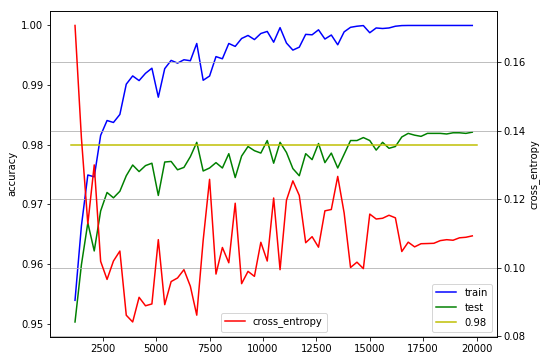

In [14]:
n_120.plot()

In [15]:
n_120.a_ce['test']

[0.1028,
 0.1135,
 0.8958,
 0.9486,
 0.9503,
 0.9599,
 0.9669,
 0.9622,
 0.9689,
 0.972,
 0.9711,
 0.9722,
 0.9748,
 0.9766,
 0.9755,
 0.9765,
 0.9769,
 0.9715,
 0.9771,
 0.9772,
 0.9758,
 0.9762,
 0.978,
 0.9804,
 0.9756,
 0.9761,
 0.977,
 0.9761,
 0.9785,
 0.9745,
 0.9781,
 0.9797,
 0.979,
 0.9786,
 0.9807,
 0.9769,
 0.9804,
 0.9787,
 0.976,
 0.9748,
 0.9785,
 0.9775,
 0.9802,
 0.977,
 0.9786,
 0.9761,
 0.9784,
 0.9807,
 0.9807,
 0.9812,
 0.9807,
 0.9791,
 0.9804,
 0.9794,
 0.9797,
 0.9813,
 0.9819,
 0.9816,
 0.9814,
 0.9819,
 0.9819,
 0.9819,
 0.9818,
 0.982,
 0.982,
 0.9819,
 0.9821]

## 结论

将这个非常简陋模型复杂化后，这个模型优化至98%以上的准确率。
Hint：
- 多隐层: 3层
- 激活函数: 一层:relu6, 二层:tanh , 三层:relu
- 正则化: 无
- 初始化: 见上面注释
- 摸索一下各个超参数
  - 隐层神经元数量:一层:784x200, 二层:200x200, 三层:200x200
  - 学习率: 0.5
  - 正则化惩罚因子: 无
  - 最好每隔300个step就对loss、accuracy等等进行一次输出，这样才能有根据地进行调整